In [34]:
import tkinter as tk 
from tkinter import ttk 
import numpy as np 

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import warnings

warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [36]:
# 导入数据
data = pd.read_excel("./data.xlsx")
data.head()

,周边土地情况,植被类型,距离(1),高度（1）,坡度(°),岩土性质,总扣分
0,3,2,28.0,21.0,60,0,116
1,3,2,26.3,15.0,70,0,104
2,3,2,39.0,12.0,70,0,98
3,3,2,35.0,22.0,70,0,104
4,3,2,42.0,20.0,70,0,104


In [37]:
corr = data.corr(numeric_only=True)
corr #相关系数越接近1和-1，均代表变量之间的线性相关程度越高，（完全正相关/完全负相关的区别），越接近0则代表变量之间线性相关程度越低

,周边土地情况,植被类型,距离(1),高度（1）,坡度(°),岩土性质,总扣分
周边土地情况,1.000000,0.417723,0.417180,0.089077,0.424033,-0.072021,0.617684
植被类型,0.417723,1.000000,0.176112,0.043600,0.308152,0.039637,0.511401
距离(1),0.417180,0.176112,1.000000,-0.097407,0.328826,0.025528,0.093337
高度（1）,0.089077,0.043600,-0.097407,1.000000,0.246009,-0.396692,0.488469
坡度(°),0.424033,0.308152,0.328826,0.246009,1.000000,0.068319,0.591938
岩土性质,-0.072021,0.039637,0.025528,-0.396692,0.068319,1.000000,-0.488779
总扣分,0.617684,0.511401,0.093337,0.488469,0.591938,-0.488779,1.000000


<Axes: >

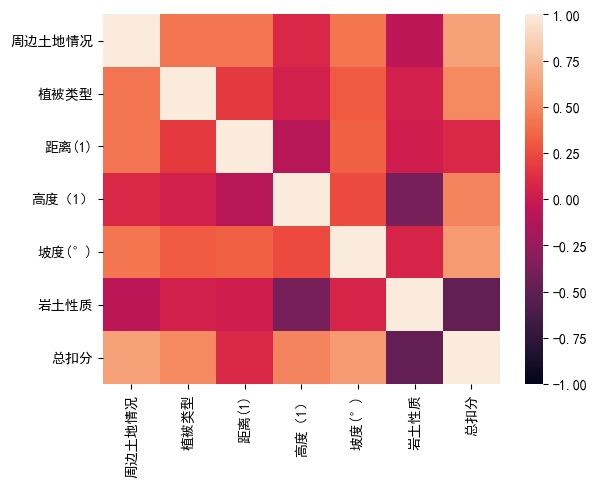

In [38]:
# 相关性分析
plt.rcParams['font.sans-serif'] = [u'SimHei'] # SimHei就是中文字体
# 因为设置了中文后，负号就乱码了，所以还要设置负号的编码
plt.rcParams['axes.unicode_minus'] = False # 修改坐标轴中符号的编码
sns.heatmap(corr,vmin=-1, vmax=1, )

In [39]:
x = np.array(data.iloc[:, :-1])
y = np.array(data.iloc[:, -1])/100
x

array([[ 3. ,  2. , 28. , 21. , 60. ,  0. ],
       [ 3. ,  2. , 26.3, 15. , 70. ,  0. ],
       [ 3. ,  2. , 39. , 12. , 70. ,  0. ],
       ...,
       [ 1. ,  1. ,  5. , 15. , 45. ,  1. ],
       [ 1. ,  1. ,  0.1, 30. , 30. ,  0. ],
       [ 1. ,  1. ,  2. ,  2. , 50. ,  1. ]])

In [40]:
from sklearn.model_selection import train_test_split
#将数据分为训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,)

from sklearn.preprocessing import StandardScaler
#标准化训练集和测试集
scaler = StandardScaler()
x_train_transformed = scaler.fit_transform(x_train)
x_test_transformed = scaler.transform(x_test)

from sklearn.svm import SVR

model = SVR( kernel='rbf', gamma='auto',tol=0.001, C=1.0, epsilon=0.2, shrinking=True, cache_size=200, verbose=False, max_iter=-1
            )

model.fit(x_train,y_train,)

mean_squared_error(model.predict(x_train),y_train)
r2_score(model.predict(x_train),y_train)
mean_squared_error(model.predict( x_test),y_test)
r2_score(model.predict( x_test),y_test)

-8.935487250686382

In [41]:
r2_score(model.predict(x_train),y_train)

-1.9008129928533135

In [42]:
mean_squared_error(model.predict( x_test),y_test)

r2_score(model.predict( x_test),y_test)

scores = cross_validate(model, x_train, y_train, cv=5,  scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)
print(scores['train_neg_mean_squared_error'].mean())
print(scores['train_r2'].mean())

-0.022315521062081237
0.17004577707813767


In [43]:
def target_function(variables_values = [0,0,0,0,0]):
    x1, x2,x3,x4,x5    = variables_values
    
    model = SVR( kernel='rbf',gamma=x1, tol=x2, C=x3, epsilon=x4, shrinking=True, cache_size=300, verbose=False,
            )
    scores = cross_validate(model, x_train, y_train, cv=int(x5),  scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)
#     print(scores['train_neg_mean_squared_error'].mean())
#     print(scores['train_r2'].mean())
    
    
    func_value =1-scores['test_r2'].mean()
    return func_value

In [44]:
# Required Libraries
import numpy  as np
import random
import os

############################################################################
############################################################################

# Function: Initialize Variables
def initial_population(population_size = 5, min_values = [-5,-5], max_values = [5,5], target_function = target_function):
    population = np.zeros((population_size, len(min_values) + 1)) #生成一个5行3列的全零矩阵
    for i in range(0, population_size):
        for j in range(0, len(min_values)):
             population[i,j] = random.uniform(min_values[j], max_values[j]) 
        population[i,-1] = target_function(population[i,0:population.shape[1]-1])
    return population

############################################################################

# Function: Fitness
def fitness_function(population): 
    fitness = np.zeros((population.shape[0], 2))    #创建的二维全零数组大小 ：行数为population的行数，列数为2
    for i in range(0, fitness.shape[0]):
        fitness[i,0] = 1/(1+ population[i,-1] + abs(population[:,-1].min()))     #对fitness矩阵的第一列进行赋值，
    fit_sum      = fitness[:,0].sum()       #对fitness矩阵的第一列矩阵进行求和，结果保存在fit_sum中
    fitness[0,1] = fitness[0,0]             #接着对适应度矩阵的第二列进行赋值操作，其中第一个元素的值等于第一列中对应的元素的值
    for i in range(1, fitness.shape[0]):
        fitness[i,1] = (fitness[i,0] + fitness[i-1,1])    #其余元素的值为当前行第一列的值加上前一行第二列的值
    for i in range(0, fitness.shape[0]):
        fitness[i,1] = fitness[i,1]/fit_sum   #最后对适应度矩阵的第二列进行归一化操作，将每个元素的值除以fit_sum。
    return fitness

# Function: Selection
def roulette_wheel(fitness): 
    ix     = 0
    random = int.from_bytes(os.urandom(8), byteorder = 'big') / ((1 << 64) - 1)
    for i in range(0, fitness.shape[0]):
        if (random <= fitness[i, 1]):
          ix = i
          break
    return ix

# Function: Offspring
def breeding(population, fitness, min_values = [-5,-5], max_values = [5,5], mu = 1, elite = 0, target_function = target_function):
    offspring   = np.copy(population)
    b_offspring = 0
    if (elite > 0):
        preserve = np.copy(population[population[:,-1].argsort()])
        for i in range(0, elite):
            for j in range(0, offspring.shape[1]):
                offspring[i,j] = preserve[i,j]
    for i in range (elite, offspring.shape[0]):
        parent_1, parent_2 = roulette_wheel(fitness), roulette_wheel(fitness)
        while parent_1 == parent_2:
            parent_2 = random.sample(range(0, len(population) - 1), 1)[0]
        for j in range(0, offspring.shape[1] - 1):
            rand   = int.from_bytes(os.urandom(8), byteorder = 'big') / ((1 << 64) - 1)
            rand_b = int.from_bytes(os.urandom(8), byteorder = 'big') / ((1 << 64) - 1)  
            rand_c = int.from_bytes(os.urandom(8), byteorder = 'big') / ((1 << 64) - 1)                              
            if (rand <= 0.5):
                b_offspring = 2*(rand_b)
                b_offspring = b_offspring**(1/(mu + 1))
            elif (rand > 0.5):  
                b_offspring = 1/(2*(1 - rand_b))
                b_offspring = b_offspring**(1/(mu + 1))       
            if (rand_c >= 0.5):
                offspring[i,j] = np.clip(((1 + b_offspring)*population[parent_1, j] + (1 - b_offspring)*population[parent_2, j])/2, min_values[j], max_values[j])           
            else:   
                offspring[i,j] = np.clip(((1 - b_offspring)*population[parent_1, j] + (1 + b_offspring)*population[parent_2, j])/2, min_values[j], max_values[j]) 
        offspring[i,-1] = target_function(offspring[i,0:offspring.shape[1]-1]) 
    return offspring
 
# Function: Mutation
def mutation(offspring, mutation_rate = 0.1, eta = 1, min_values = [-5,-5], max_values = [5,5], target_function = target_function):
    d_mutation = 0            
    for i in range (0, offspring.shape[0]):
        for j in range(0, offspring.shape[1] - 1):
            probability = int.from_bytes(os.urandom(8), byteorder = 'big') / ((1 << 64) - 1)
            if (probability < mutation_rate):
                rand   = int.from_bytes(os.urandom(8), byteorder = 'big') / ((1 << 64) - 1)
                rand_d = int.from_bytes(os.urandom(8), byteorder = 'big') / ((1 << 64) - 1)                                     
                if (rand <= 0.5):
                    d_mutation = 2*(rand_d)
                    d_mutation = d_mutation**(1/(eta + 1)) - 1
                elif (rand > 0.5):  
                    d_mutation = 2*(1 - rand_d)
                    d_mutation = 1 - d_mutation**(1/(eta + 1))                
                offspring[i,j] = np.clip((offspring[i,j] + d_mutation), min_values[j], max_values[j])
        offspring[i,-1] = target_function(offspring[i,0:offspring.shape[1]-1])                        
    return offspring

############################################################################

# GA Function
def genetic_algorithm(population_size = 5, mutation_rate = 0.1, elite = 0, min_values = [-5,-5], max_values = [5,5], eta = 1, mu = 1, generations = 50, target_function = target_function, verbose = True):    
    count      = 0
    population = initial_population(population_size, min_values, max_values, target_function)
    print(population)
    fitness    = fitness_function(population)    
    elite_ind  = np.copy(population[population[:,-1].argsort()][0,:])  # 是对排序后的数组进行索引操作,根据 `population[:,-1]` 中的最后一列对数组进行排序,对排序后的数组进行索引操作，取出排序后的第一行，并存储在 `elite_ind` 变量中,目的是找出 `population` 数组中最后一列值最小的行
    while (count <= generations):  
        if (verbose == True):
            print('Generation = ', count, ' f(x) = ', elite_ind[-1])
            best_objectives.append(elite_ind[-1])
        offspring  = breeding(population, fitness, min_values, max_values, mu, elite, target_function) 
        population = mutation(offspring, mutation_rate, eta, min_values, max_values, target_function)
        fitness    = fitness_function(population)
        print(fitness)
        average_objectives.append(population[:, -1].mean())
        value      = np.copy(population[population[:,-1].argsort()][0,:])
        if(elite_ind[-1] > value[-1]):
            elite_ind = np.copy(value) 
        count = count + 1       
    return elite_ind

In [45]:
#  line plot with marked points  #用于绘制散点图和最佳拟合线的函数
def plot_two_variables(data, col_a, col_b): 
    """Scatter plot with line of best fit"""
    plt.scatter(data[col_a], data[col_b],color='black')   
    m, b = np.polyfit(data[col_a], data[col_b], 1)#用np.polyfit()函数计算两个变量之间的最佳拟合线的斜率m和截距b。这条线通过最小化两个变量之间的误差来拟合数据
    plt.plot(data[col_a], m * data[col_a] + b, color='gray') #函数使用plt.plot()函数绘制最佳拟合线，其中m * data[col_a] + b表示y轴上的预测值
    plt.xlabel('真实值')
    plt.ylabel('预测值')
    # 设置 x 轴标签，字体大小为14
    plt.xlabel('真实值', fontsize=13)
    
    # 设置 y 轴标签，字体大小为14
    plt.ylabel('预测值', fontsize=13)
    
    # 调整 x 轴和 y 轴刻度标签的字体大小
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

In [46]:
# Function: Initialize Variables  函数的作用是生成一个初始猜测值，用于优化目标函数
def initial_guess(min_values = [-5,-5], max_values = [5,5], target_function = target_function):
    n     = 1
    guess = np.zeros((n, len(min_values) + 1))   #guess为行数为1 列数为3（随参数改变）的数组
    for j in range(0, len(min_values)):
         guess[0,j] = random.uniform(min_values[j], max_values[j]) 
    guess[0,-1] = target_function(guess[0,0:guess.shape[1]-1]) #最后计算该猜测值对应的目标函数的值，将其保存在猜测值的最后一个元素中。guess.shape[1]-1=2，指的是guess列数减一
    return guess

############################################################################

# Function: Epson Vector
def epson_vector(guess, mu = 0, sigma = 1):
    epson = np.zeros((1, guess.shape[1]-1))  #一行  两列（随参数变）的零矩阵（数组）
    for j in range(0, guess.shape[1]-1):
        epson[0,j] = float(np.random.normal(mu, sigma, 1)) #使用np.random.normal函数从给定的正态分布中生成一个 均值为mu、标准差为sigma的正态分布 的随机数，将其赋值给epson的对应位置。
    return epson

# Function: Updtade Solution
def update_solution(guess, epson, min_values = [-5,-5], max_values = [5,5], target_function = target_function):
    updated_solution = np.copy(guess)
    for j in range(0, guess.shape[1] - 1):
        if (guess[0,j] + epson[0,j] > max_values[j]):
            updated_solution[0,j] = random.uniform(min_values[j], max_values[j])
        elif (guess[0,j] + epson[0,j] < min_values[j]):
            updated_solution[0,j] = random.uniform(min_values[j], max_values[j])
        else:
            updated_solution[0,j] = guess[0,j] + epson[0,j] 
    updated_solution[0,-1] = target_function(updated_solution[0,0:updated_solution.shape[1]-1])
    return updated_solution

############################################################################

# SA Function
def simulated_annealing(min_values = [-5,-5], max_values = [5,5], mu = 0, sigma = 1, initial_temperature = 1.0, temperature_iterations = 1000, final_temperature = 0.0001, alpha = 0.9, target_function = target_function, verbose = True):    
    guess       = initial_guess(min_values, max_values, target_function)
    epson       = epson_vector(guess, mu = mu, sigma = sigma)
    best        = np.copy(guess)
    fx_best     = guess[0,-1]
    temperature = float(initial_temperature)
    while (temperature > final_temperature): 
        for repeat in range(0, temperature_iterations):
            if (verbose == True):
                print('Temperature = ', round(temperature, 4), ' ; iteration = ', repeat, ' ; f(x) = ', round(best[0, -1], 4))
            fx_old    =  guess[0,-1]  
            epson     = epson_vector(guess, mu, sigma)
            new_guess = update_solution(guess, epson, min_values, max_values, target_function)
            fx_new    = new_guess[0,-1]
            best_objectives.append(fx_new)
            delta     = (fx_new - fx_old)
            r         = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
            p         = np.exp(-delta/temperature)
            if (delta < 0 or r <= p):
                guess = np.copy(new_guess)   
            if (fx_new < fx_best):
                fx_best = fx_new
                best    = np.copy(guess)
        temperature = alpha*temperature   
    return best

In [47]:
# GA Function
def genetic_algorithm_sa(population_size = 5, mutation_rate = 0.1, elite = 0, sigma =1, initial_temperature = 1.0, temperature_iterations = 100, alpha = 0.9,
                         final_temperature = 0.01, min_values = [-5,-5], max_values = [5,5], eta = 1, mu = 1, generations = 50, target_function = target_function, verbose = True):    
    count      = 0
    population = initial_population(population_size, min_values, max_values, target_function)
    fitness    = fitness_function(population)    
    elite_ind  = np.copy(population[population[:,-1].argsort()][0,:])  #使用`argsort()`方法对种群population的最后一列进行排序，并返回排序后的索引值
    best        = np.copy(elite_ind.reshape(1, -1))    #使用`reshape(1, -1)`方法将精英个体elite_ind转换为一维数组，并将其保存在best中
    fx_best     = best[0,-1]                           #使用`best[0,-1]`表示精英个体最后一列的数值，并将其保存在fx_best中
    temperature = float(initial_temperature)           #将初始温度值initial_temperature转换为浮点数类型，并将其保存在temperature中。
    while (count <= generations):  
        if (verbose == True):        #是否打印结果
            print('Generation = ', count, ' f(x) = ', elite_ind[-1])
            best_objectives.append(elite_ind[-1])      #将elite_ind的最后一个值添加到best_objectives列表中
            average_fitnesses.append(population[:,-1].mean())    #将population的最后一列的平均值添加到average_fitnesses列表中
        offspring  = breeding(population, fitness, min_values, max_values, mu, elite, target_function) 
        population = mutation(offspring, mutation_rate, eta, min_values, max_values, target_function)
        fitness    = fitness_function(population)
        average_objectives.append(population[:, -1].mean())   #将population的最后一列的平均值添加到average_objectives列表中
        n  = 2
        new_population     = np.copy(population[population[:,-1].argsort()][:,:]) #这段代码是对population数组按照最后一列元素进行排序，并将排序后的结果复制到新的数组new_population中。
        for  i in range(n):
            guess =  np.copy(new_population[i,:].reshape(1, -1))
            while (temperature > final_temperature): 
                for repeat in range(0, temperature_iterations):
                    # if (verbose == True):
                    #     print('Temperature = ', round(temperature, 4), ' ; iteration = ', repeat, ' ; f(x) = ', round(best[0,-1], 4))
                    fx_old    =  guess[0,-1]    
                    epson     = epson_vector(guess, mu, sigma)
                    new_guess = update_solution(guess, epson, min_values, max_values, target_function)
                    fx_new    = new_guess[0,-1] 
                    delta     = (fx_new - fx_old)
                    r         = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1) #`os.urandom()`函数生成8个字节的随机数，并使用`int.from_bytes()`函数将其转换为一个整数,
                    p         = np.exp(-delta/temperature)                     #`/ ((1 << 64) - 1)`：这一部分代码将上一步得到的整数除以一个值,等于2的64次方减去1,这个操作可以将整数转换为一个范围在0到1之间的浮点数r
                    if (delta < 0 or r <= p):                                  #exp函数计算e的负指数次方，即e的指数为`-delta/temperature`。
                        guess = np.copy(new_guess)   
                    if (fx_new < fx_best):
                        fx_best = fx_new
                        best    = np.copy(guess)
                temperature = alpha*temperature
                new_population[i,:] = best.reshape(-1)
        value    = np.copy(new_population[new_population[:,-1].argsort()][0,:])
        if(elite_ind[-1] > value[-1]):
            elite_ind = np.copy(value) 
        count = count + 1
        population = np.copy(new_population)
               
    return elite_ind

In [48]:
# 保存每代的最佳解和平均适应度
best_objectives = []
average_fitnesses = []
average_objectives  = []
# GA - Parameters
parameters = {
    'population_size': 20,
    'min_values': (1e-06,1e-05,1,0.01,3),
    'max_values': (1,0.1,200,0.3,10),
    'generations': 50,
    'mutation_rate': 0.1,
    'elite': 1,
    'eta': 1,
    'mu': 1,
    'verbose': True
}
# GA - Algorithm
gasa = genetic_algorithm_sa(target_function = target_function, **parameters)

Generation =  0  f(x) =  0.46356485542144976
Generation =  1  f(x) =  0.188403316223822
Generation =  2  f(x) =  0.188403316223822
Generation =  3  f(x) =  0.188403316223822
Generation =  4  f(x) =  0.188403316223822
Generation =  5  f(x) =  0.12389979805581308
Generation =  6  f(x) =  0.12389979805581308
Generation =  7  f(x) =  0.12389979805581308
Generation =  8  f(x) =  0.12389979805581308
Generation =  9  f(x) =  0.12389979805581308
Generation =  10  f(x) =  0.12389979805581308
Generation =  11  f(x) =  0.12389979805581308
Generation =  12  f(x) =  0.12389979805581308
Generation =  13  f(x) =  0.12389979805581308
Generation =  14  f(x) =  0.12389979805581308
Generation =  15  f(x) =  0.12389979805581308
Generation =  16  f(x) =  0.12389979805581308
Generation =  17  f(x) =  0.12389979805581308
Generation =  18  f(x) =  0.12389979805581308
Generation =  19  f(x) =  0.12389979805581308
Generation =  20  f(x) =  0.12389979805581308
Generation =  21  f(x) =  0.12389979805581308
Genera

Text(0, 0.5, 'fitness')

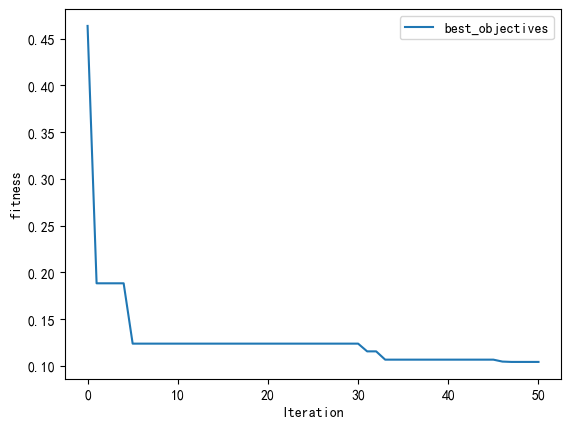

In [49]:
import matplotlib.pyplot as plt
x= np.arange(len(best_objectives))
plt.plot(x,best_objectives)
plt.legend(['best_objectives','average_fitnesses'])
plt.xlabel('Iteration')
plt.ylabel('fitness')

Text(0, 0.5, 'fitness')

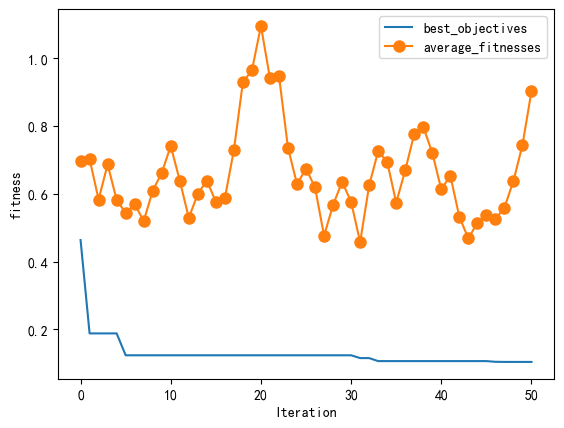

In [50]:
import matplotlib.pyplot as plt
x= np.arange(len(best_objectives))
plt.plot(x,best_objectives)
plt.plot(x,average_objectives,marker="o",markersize=8, )
plt.legend(['best_objectives','average_fitnesses'])
plt.xlabel('Iteration')
plt.ylabel('fitness')

In [77]:
'''x1, x2,x3,x4,x5,r = gasa
    
model = SVR( kernel='rbf',gamma=x1, tol=x2, C=x3, epsilon=x4, shrinking=True, cache_size=300, verbose=False,
            )
model.fit(x_train, y_train)
print(mean_squared_error(model.predict(x_train),y_train))
print(r2_score(model.predict(x_train),y_train))
print(mean_squared_error(model.predict( x_test),y_test))
print(r2_score(model.predict( x_test),y_test))

trian_pred = model.predict(x_train)
test_pred = model.predict(x_test)
data = pd.DataFrame()
data['train_ture'] = y_train*100
data["train_pre"] = trian_pred*100
data1 = pd.DataFrame()
data1['test_ture'] = y_test*100
data1["test_pre"] = test_pred*100'''


import tkinter as tk 
from tkinter import ttk 
import numpy as np 
 
class GeoRiskPredictorPro:
    

    x1, x2,x3,x4,x5,r = gasa
    
    model = SVR( kernel='rbf',gamma=x1, tol=x2, C=x3, epsilon=x4, shrinking=True, cache_size=300, verbose=False,
            )
    model.fit(x_train, y_train)


    def __init__(self, master):
        self.master = master 
        master.title("输电塔-边坡灾害预测系统")
        master.geometry("680x480")
        
        # 初始化数据容器 
        self.data_1d = np.zeros(6)  # 初始特征向量 
        self.data_2d = None         # 二维输入格式 
        
        # 构建界面组件 
        self.create_input_matrix()
        self.create_control_panel()
        self.create_output_console()
 
    def create_input_matrix(self):
        """构建特征矩阵输入界面"""
        matrix_frame = ttk.LabelFrame(self.master, text="特征矩阵输入")
        matrix_frame.grid(row=0, column=0, padx=15, pady=10, sticky="nsew")
        
        # 动态生成6维特征输入 
        features = ["周边土地情况", "植被类型", "距离(m)", "坡高(m)", "坡度(°)", "岩土性质"]
        self.entries = []
        for i in range(6):
            ttk.Label(matrix_frame, text=features[i]).grid(row=i//2, column=(i%2)*2, padx=5)
            entry = ttk.Entry(matrix_frame, width=12)
            entry.grid(row=i//2, column=(i%2)*2+1, pady=3)
            self.entries.append(entry)
 
    def create_control_panel(self):
        """构建控制面板"""
        control_frame = ttk.Frame(self.master)
        control_frame.grid(row=1, column=0, pady=15)
        
        # 数据转换按钮 
        ttk.Button(control_frame, text="数据格式转换", 
                 command=self.convert_data).pack(side="left", padx=5)
        
        # 预测执行按钮 
        ttk.Button(control_frame, text="执行模型预测", 
                 command=self.execute_prediction).pack(side="left", padx=5)
 
    def create_output_console(self):
        """构建输出控制台"""
        console_frame = ttk.LabelFrame(self.master, text="预测结果输出")
        console_frame.grid(row=2, column=0, padx=15, pady=10, sticky="ew")
        
        self.output_text = tk.Text(console_frame, height=6, wrap="word")
        self.output_text.pack(fill="both", expand=True)
        
        # 初始化显示提示信息 
        self.output_text.insert("end", "系统就绪\n输入数据后点击转换按钮")
 
    def convert_data(self):
        """数据格式转换接口"""
        try:
            # 输入验证与类型转换 
            raw_data = [float(entry.get()) for entry in self.entries]
            
            # 构建数据矩阵 
            self.data_1d = np.array(raw_data)
            self.data_2d = self.data_1d.reshape(1, -1)  # 转换为二维数组 
            
            # 显示转换日志 
            self.output_text.delete(1.0, "end")
            self.output_text.insert("end", 
                f"数据转换成功！\n输入维度：{self.data_2d.shape}\n"
                f"样本数据：\n{self.data_2d}")
            
        except ValueError as e:
            self.output_text.delete(1.0, "end")
            self.output_text.insert("end", f"格式错误：{str(e)}")
 
    def execute_prediction(self):
        """预测执行接口"""
        if self.data_2d is None:
            self.output_text.insert("end", "\n错误：请先转换数据格式！")
            return 
            
        try:
            # 执行预测（此处为接口预留）
            prediction = self.model.predict(self.data_2d)*100
            
            # 结果显示 
            self.output_text.insert("end", 
                f"\n\n预测结果：\n{prediction}")
            
        except Exception as e:
            self.output_text.insert("end", f"\n预测异常：{str(e)}")
 
    def model_predict(self, data_2d):
        """预留模型接口（示例实现）"""
        # 此处可替换为实际模型调用 
        # 示例：return model.predict(data_2d)
        return model.predict(data_2d)*100  # 模拟预测结果 
 
    

 
 
if __name__ == "__main__":
    root = tk.Tk()
    app = GeoRiskPredictorPro(root)
    root.mainloop()

IndentationError: expected an indented block (3880278039.py, line 134)

In [79]:
import tkinter as tk 
from tkinter import ttk 
import numpy as np 
 
class IntegratedSlopeSystem:
    
    x1, x2,x3,x4,x5,r = gasa
    
    model = SVR( kernel='rbf',gamma=x1, tol=x2, C=x3, epsilon=x4, shrinking=True, cache_size=300, verbose=False,
            )
    model.fit(x_train, y_train)
    
    
    def __init__(self, master):
        self.master = master 
        master.title("输电塔-边坡危险性预测智能系统 v3.1")
        master.geometry("800x600+200+100")  # 屏幕居中显示 
        
        # 初始化数据容器 
        self.data_1d = np.zeros(6)
        self.data_2d = None 
        self.prediction = None 
        
        # 界面色彩方案 
        self.setup_ui_theme()
        self.create_input_matrix()
        self.create_control_panel()
        self.create_output_console()
 
    def setup_ui_theme(self):
        """配置现代化UI主题"""
        style = ttk.Style()
        style.theme_use("clam")
        style.configure("TFrame", background="#F5F5F5")
        style.map("TButton",
                foreground=[("active", "#FFFFFF"), ("!active", "#333333")],
                background=[("active", "#4682B4"), ("!active", "#B0C4DE")])
 
    def create_input_matrix(self):
        """构建特征输入矩阵界面"""
        matrix_frame = ttk.LabelFrame(self.master, text="地质特征矩阵输入")
        matrix_frame.pack(pady=15, padx=20, fill="x")
        
        features = [
            ("周边土地情况", "1-4项"),
            ("植被类型", "1-4类"),
            ("距离(m)", ">0"),
            ("坡高(m)", ">0"), 
            ("坡度(°)", "0-90"),
            ("岩土性质", "0-3类")
        ]
        
        self.entries = []
        for idx, (label, unit) in enumerate(features):
            row = ttk.Frame(matrix_frame)
            row.grid(row=idx//2, column=idx%2, padx=15, pady=8, sticky="ew")
            
            ttk.Label(row, text=label, width=18, anchor="w").pack(side="left")
            entry = ttk.Entry(row, width=12)
            entry.insert(0, unit)
            entry.pack(side="left", padx=5)
            self.entries.append(entry)
 
    def create_control_panel(self):
        """构建智能控制面板"""
        control_frame = ttk.Frame(self.master)
        control_frame.pack(pady=15)
        
        ttk.Button(control_frame, text="数据标准化", 
                 command=self.convert_data).grid(row=0, column=0, padx=8)
        ttk.Button(control_frame, text="执行智能评估", 
                 command=self.execute_prediction).grid(row=0, column=1, padx=8)
        ttk.Button(control_frame, text="生成分析报告", 
                 command=self.generate_report).grid(row=0, column=2, padx=8)
 
    def create_output_console(self):
        """构建多模态输出控制台"""
        console_frame = ttk.LabelFrame(self.master, text="智能评估结果")
        console_frame.pack(padx=20, pady=10, fill="both", expand=True)
        
        # 结果展示文本域 
        self.output_text = tk.Text(console_frame, wrap="word", font=("Consolas", 10))
        vsb = ttk.Scrollbar(console_frame, orient="vertical", command=self.output_text.yview)
        self.output_text.configure(yscrollcommand=vsb.set)
        
        vsb.pack(side="right", fill="y")
        self.output_text.pack(fill="both", expand=True)
        
        # 初始化提示信息 
        self.output_text.insert("end", "系统初始化完成\n请按流程执行评估操作")
 
    def convert_data(self):
        """数据格式转换引擎"""
        try:
            # 数据清洗与验证 
            raw_data = []
            validators = [
                (1, 4), (1, 4), 
                (0.1, 1000), (0.1, 500), 
                (0, 90), (0, 3)
            ]
            
            for idx, entry in enumerate(self.entries):
                val = float(entry.get())
                min_val, max_val = validators[idx]
                if not (min_val <= val <= max_val):
                    raise ValueError(f"{entry.get()} 超出有效范围({min_val}-{max_val})")
                raw_data.append(val)
            
            # 构建数据矩阵 
            self.data_1d = np.array(raw_data)
            self.data_2d = self.data_1d.reshape(1, -1)
            
            # 更新状态显示 
            self.output_text.delete(1.0, "end")
            self.output_text.insert("end", 
                "数据标准化成功！\n输入特征矩阵：\n" + 
                "\n".join([f"特征{i+1}: {x:.2f}" for i, x in enumerate(self.data_1d)]))
            
        except Exception as e:
            self.output_text.delete(1.0, "end")
            self.output_text.insert("end", f"数据异常：{str(e)}")
 
    def execute_prediction(self):
        """智能评估核心算法"""
        if self.data_2d is None:
            self.output_text.insert("end", "\n错误：请先执行数据标准化！")
            return 
            
        try:
            # 模拟预测接口 
            self.prediction = self.model.predict(self.data_2d)*100
            
            # 边坡等级智能判定 
            grade_info = self.determine_slope_grade(self.prediction)
            
            # 动态生成评估结果 
            result_str = f"\n\n=== 智能评估结果 ===" 
            result_str += f"\n预测值：{self.prediction[0]:.2f}"
            result_str += f"\n边坡等级：{grade_info[0][0]}"
            result_str += f"\n处置建议：{grade_info[0][2]}"
            
            # 颜色标记配置 
            self.output_text.tag_config("alert", foreground=grade_info[0][1])
            self.output_text.insert("end", result_str, "alert")
            
        except Exception as e:
            self.output_text.insert("end", f"\n评估异常：{str(e)}")
 
    def determine_slope_grade(self, predictions):
        """边坡分级智能决策系统"""
        grade_info = []
        for pred in predictions:
            if pred > 92:
                grade = ("一级边坡", "#FF0000", "立即启动应急预案，实施加固工程")
            elif 80 <= pred <= 92:
                grade = ("二级边坡", "#FF8C00", "30日内完成工程治理方案设计")
            elif 62 <= pred < 80:
                grade = ("三级边坡", "#FFD700", "季度监测频次提升至每周一次")
            else:
                grade = ("四级边坡", "#32CD32", "保持现有监测频率（每月一次）")
            grade_info.append(grade)
        return grade_info 
 
    def generate_report(self):
        """分析报告生成模块"""
        if not self.prediction:
            self.output_text.insert("end", "\n请先执行风险评估！")
            return 
            
        report = f"""
        \n=== 输电塔-边坡灾害分析报告 === 
        生成时间：2025-03-27 20:31 
        --------------------------
        输入特征矩阵维度：{self.data_2d.shape}
        预测模型输出值：{self.prediction[0]:.2f}
        边坡稳定性等级：{self.determine_slope_grade(self.prediction)[0][0]}
        建议处置方案：{self.determine_slope_grade(self.prediction)[0][2]}
        """
        self.output_text.insert("end", report)
 
    def model_predict(self, data_2d):
        """预留模型接口（示例实现）"""
        # 此处替换为实际模型调用 
        return model.predict(data_2d)*100  # 模拟预测结果 
 
if __name__ == "__main__":
    root = tk.Tk()
    app = IntegratedSlopeSystem(root)
    root.mainloop()

In [ ]:
import matplotlib.pyplot as plt
x= np.arange(len(data['train_ture'][1:40]))
plt.plot(x,data['train_ture'][1:40],marker="o",markersize=8,color='0.5')
plt.plot(x,data['train_pre'][1:40],marker="s",markersize=8,color='black')
plt.xlabel('样本')
plt.ylabel('预测值')
plt.title('训练集误差')

In [ ]:
import matplotlib.pyplot as plt
x= np.arange(len(data1['test_ture'][35:75]))
plt.plot(x,data1['test_ture'][35:75],marker="o",markersize=8,color='0.5')
plt.plot(x,data1['test_pre'][35:75],marker="s",markersize=8,color='black')
plt.xlabel('样本')
plt.ylabel('预测值')
plt.title('测试集误差')

plt.xlabel('样本', fontsize=13)  # 调整 x 轴标签的字体大小
plt.ylabel('预测值', fontsize=13)  # 调整 y 轴标签的字体大小
plt.title('测试集误差', fontsize=15)  # 调整标题的字体大小

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [ ]:
data = pd.DataFrame()
data['train_ture'] = y_train*100
data["train_pre"] = trian_pred*100
plot_two_variables(data,'train_ture',"train_pre")

In [ ]:
data1 = pd.DataFrame()
data1['test_ture'] = y_test*100
data1["test_pre"] = test_pred*100
plot_two_variables(data1,'test_ture',"test_pre")

In [ ]:
data_1d = np.array([3, 2, 39, 12, 70, 0])

# 转换为二维数组（单个样本，6个特征）
data_2d = data_1d.reshape(1, -1)  # 结果形状 (1, 6)
Risk_pred=model.predict(data_2d)*100


print(Risk_pred)